# Analysis

In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

In [15]:
from google.cloud import bigquery
from google.oauth2 import service_account
credentials = service_account.Credentials.from_service_account_file(
'../.keys/sctp-data-eng-ecomm-5e533c859ea1.json')

project_id = 'sctp-data-eng-ecomm'
client = bigquery.Client(credentials= credentials,project=project_id)

In [16]:
query_job = client.query("""
   SELECT *
   FROM ecomm_dev.fact_order_items
   LIMIT 1000 """)

In [17]:
# Convert results to a Pandas DataFrame
df = query_job.to_dataframe()

# Display the DataFrame
print(df.head())

                           order_id  order_item_id  \
0  d455a8cb295653b55abda06d434ab492              1   
1  9dc8d1a6f16f1b89874c29c9d8d30447              1   
2  7f39ba4c9052be115350065d07583cac              1   
3  2b877f0d1e2a876f0e5cb30125336a8a              1   
4  213ede0c70c581ede2b365194da6d2fe              1   

                         product_id                         seller_id  \
0  a2ff5a97bf95719e38ea2e3b4105bce8  0015a82c2db000af6aaaf3ae2ecb0532   
1  a2ff5a97bf95719e38ea2e3b4105bce8  0015a82c2db000af6aaaf3ae2ecb0532   
2  a2ff5a97bf95719e38ea2e3b4105bce8  0015a82c2db000af6aaaf3ae2ecb0532   
3  08574b074924071f4e201e151b152b4e  001cca7ae9ae17fb1caed9dfb1094831   
4  08574b074924071f4e201e151b152b4e  001cca7ae9ae17fb1caed9dfb1094831   

  shipping_limit_date  price  freight_value                       customer_id  \
0 2017-10-12 22:24:16  895.0          21.02  944b72539d7e1f7f7fc6e46639ef1fe3   
1 2017-10-18 14:49:22  895.0          21.02  d9442164acf4b03109425633efaa0

In [21]:
query = """

WITH merged_orders_payments AS (
  SELECT
    o.order_id,
    o.customer_id,
    o.order_status,
    o.order_purchase_timestamp,
    p.payment_type,
    p.payment_installments,
    p.payment_value
  FROM
    `sctp-data-eng-ecomm.ecomm_dev.stg_orders` o
  JOIN
    `sctp-data-eng-ecomm.ecomm_dev.stg_payments` p
  ON
    o.order_id = p.order_id
),
monthly_sales AS (
  SELECT
    FORMAT_DATE('%Y-%m', DATE(order_purchase_timestamp)) AS order_month,
    SUM(payment_value) AS total_sales
  FROM
    merged_orders_payments
  GROUP BY
    order_month
  ORDER BY
    order_month
)
SELECT * FROM monthly_sales;
"""
df = client.query(query).to_dataframe()
print(df)

   order_month  total_sales
0      2016-09       252.24
1      2016-10     59090.48
2      2016-12        19.62
3      2017-01    138488.04
4      2017-02    291908.01
5      2017-03    449863.60
6      2017-04    417788.03
7      2017-05    592724.82
8      2017-06    511276.38
9      2017-07    592382.92
10     2017-08    674396.32
11     2017-09    727762.45
12     2017-10    779677.88
13     2017-11   1194747.97
14     2017-12    878401.48
15     2018-01   1115004.18
16     2018-02    992463.34
17     2018-03   1159652.12
18     2018-04   1160785.48
19     2018-05   1153982.15
20     2018-06   1023351.17
21     2018-07   1066019.99
22     2018-08   1022425.32
23     2018-09      4439.54
24     2018-10       589.67


In [ ]:
query = """
SELECT
  product_category_name,
  SUM(price) AS total_sales
FROM
  `sctp-data-eng-ecomm.ecomm_dev.fact_order_items`
WHERE
  product_category_name IS NOT NULL
GROUP BY
  product_category_name
ORDER BY
  total_sales DESC
LIMIT 10;
"""

df = client.query(query).to_dataframe()
print(df)

   product_category_name  total_sales
0          watches_gifts   1212634.70
1          health_beauty   1201112.38
2         sports_leisure    935962.59
3         bed_bath_table    917589.63
4  computers_accessories    797615.43
5             cool_stuff    635915.34
6        furniture_decor    612774.78
7             housewares    589981.12
8                   auto    567389.97
9                   toys    478665.36


In [23]:
query = """
SELECT
  FORMAT_TIMESTAMP('%A',order_purchase_timestamp) AS day_of_week,
  SUM(price) AS total_sales
FROM
  `sctp-data-eng-ecomm.ecomm_dev.fact_order_items`
WHERE
  order_purchase_timestamp IS NOT NULL
  AND price IS NOT NULL
GROUP BY
  day_of_week
ORDER BY
  total_sales DESC
LIMIT 7;
"""

df = client.query(query).to_dataframe()
print(df)

  day_of_week  total_sales
0      Monday   2123493.16
1     Tuesday   2063469.39
2   Wednesday   2032092.11
3    Thursday   1935052.93
4      Friday   1846949.08
5      Sunday   1531355.59
6    Saturday   1456422.43


In [24]:
query = """
SELECT
  payment_type,
  COUNT(*) AS transaction_count
FROM
  `sctp-data-eng-ecomm.ecomm_dev.fact_order_items`
WHERE
  payment_type IS NOT NULL
GROUP BY
  payment_type
ORDER BY
  transaction_count DESC
"""

df = client.query(query).to_dataframe()
print(df)

  payment_type  transaction_count
0  credit_card              76271
1       boleto              19614
2      voucher               5642
3   debit_card               1521


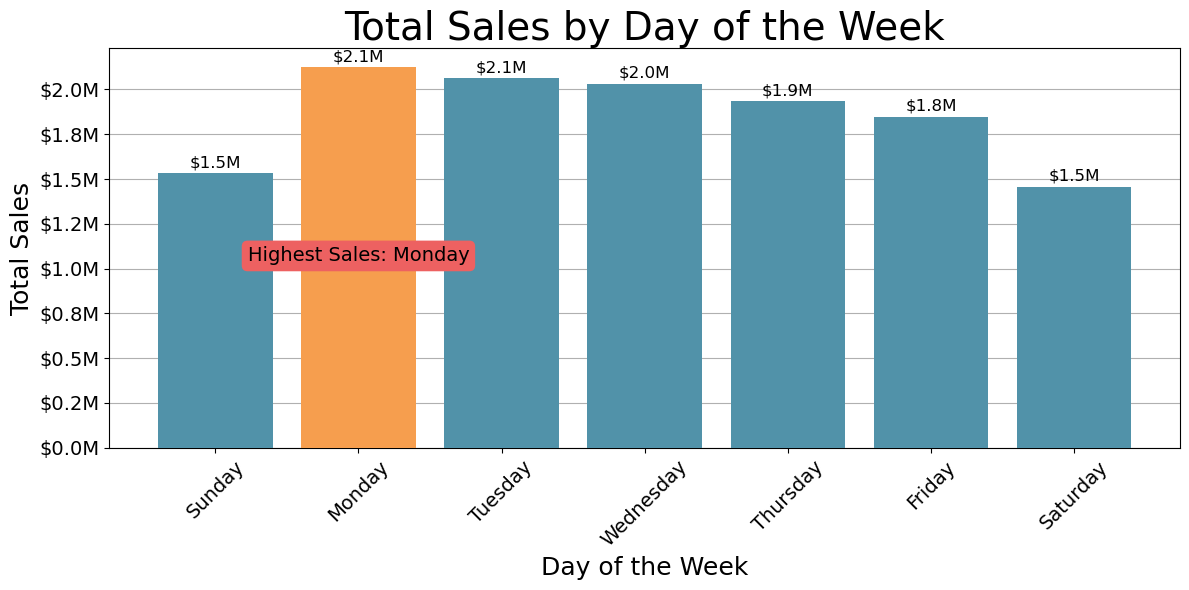

In [31]:
query = """
WITH daily_sales AS (
  SELECT
    FORMAT_TIMESTAMP('%A', order_purchase_timestamp) AS day_of_week,
    EXTRACT(DAYOFWEEK FROM order_purchase_timestamp) AS weekday_number,
    SUM(price) AS total_sales
  FROM
    `sctp-data-eng-ecomm.ecomm_dev.fact_order_items`
  WHERE
    order_purchase_timestamp IS NOT NULL
    AND price IS NOT NULL
  GROUP BY
    day_of_week, weekday_number
)
SELECT
  day_of_week,
  total_sales
FROM
  daily_sales
ORDER BY
  weekday_number;
"""
df = client.query(query).to_dataframe()

top_day = df.loc[df["total_sales"].idxmax(), "day_of_week"]
top_value = df["total_sales"].max()
top_index = df["total_sales"].idxmax()

colors = ["#5192A9" if day != top_day else "#f69e4e" for day in df["day_of_week"]]


plt.figure(figsize=(12, 6))
bars = plt.bar(df["day_of_week"], df["total_sales"], color=colors, zorder=3)

plt.title("Total Sales by Day of the Week", fontsize=28)
plt.xlabel("Day of the Week", fontsize=18)
plt.ylabel("Total Sales", fontsize=18)
plt.xticks(rotation=45, fontsize=14)
plt.yticks(fontsize=14)
plt.grid(axis='y')

plt.gca().yaxis.set_major_formatter(mtick.FuncFormatter(lambda x, _: f'${x/1e6:.1f}M'))


for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height + 1e5,
             f"${height / 1e6:.1f}M", ha='center', va='top', fontsize=12)


plt.annotate(f"Highest Sales: {top_day}", xy=(top_index, top_value),
             xytext=(top_index, top_value - 1e6), 
             ha='center', va='top',
             color='black', fontsize=14,
             bbox=dict(boxstyle="round,pad=0.3", facecolor="#ED6161", edgecolor="none"))

plt.tight_layout()
plt.show()


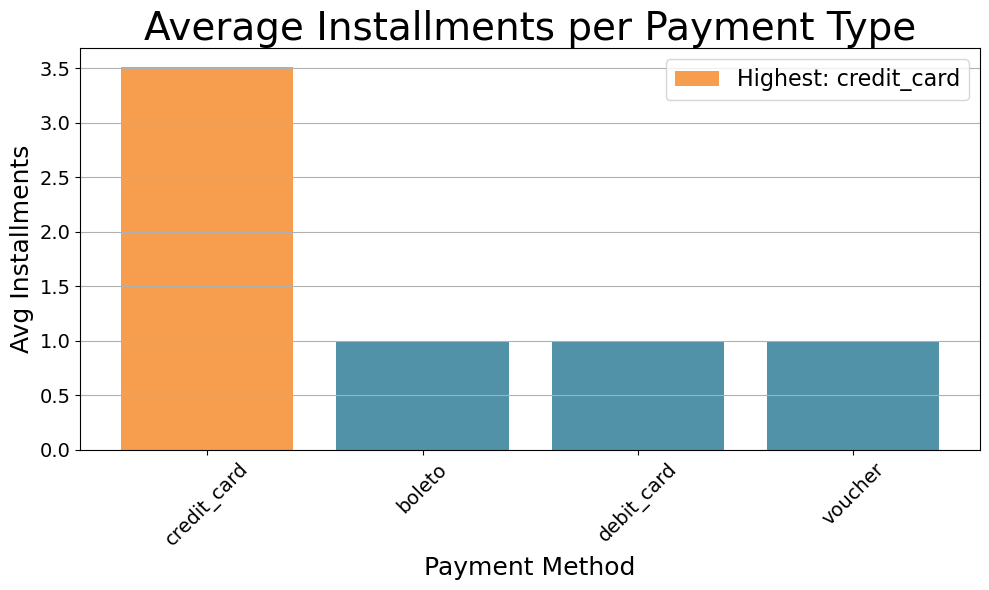

In [ ]:
# Initialize BigQuery client
client = bigquery.Client(project='sctp-data-eng-ecomm')

# Query: Average Installments per Payment Type
query3 = """
SELECT
  payment_type,
  AVG(payment_installments) AS avg_installments
FROM `sctp-data-eng-ecomm.ecomm_dev.fact_order_items`
WHERE payment_installments IS NOT NULL
GROUP BY payment_type
"""
df3 = client.query(query3).to_dataframe()

# Identify the payment method with the highest average installments
max_idx = df3['avg_installments'].idxmax()
highlight_color = '#f69e4e'  # Orange
default_color = '#5192A9'    # Blue
colors = [highlight_color if i == max_idx else default_color for i in range(len(df3))]

# Plotting
plt.figure(figsize=(10, 6))
bars = plt.bar(df3["payment_type"], df3["avg_installments"], color=colors)

# Labels and formatting
plt.title("Average Installments per Payment Type", fontsize=28)
plt.xlabel("Payment Method", fontsize=18)
plt.ylabel("Avg Installments", fontsize=18)
plt.xticks(rotation=45, fontsize=14)
plt.yticks(fontsize=14)
plt.legend([f'Highest: {df3.loc[max_idx, "payment_type"]}'], fontsize=16)
plt.grid(axis='y')
plt.tight_layout()
plt.show()


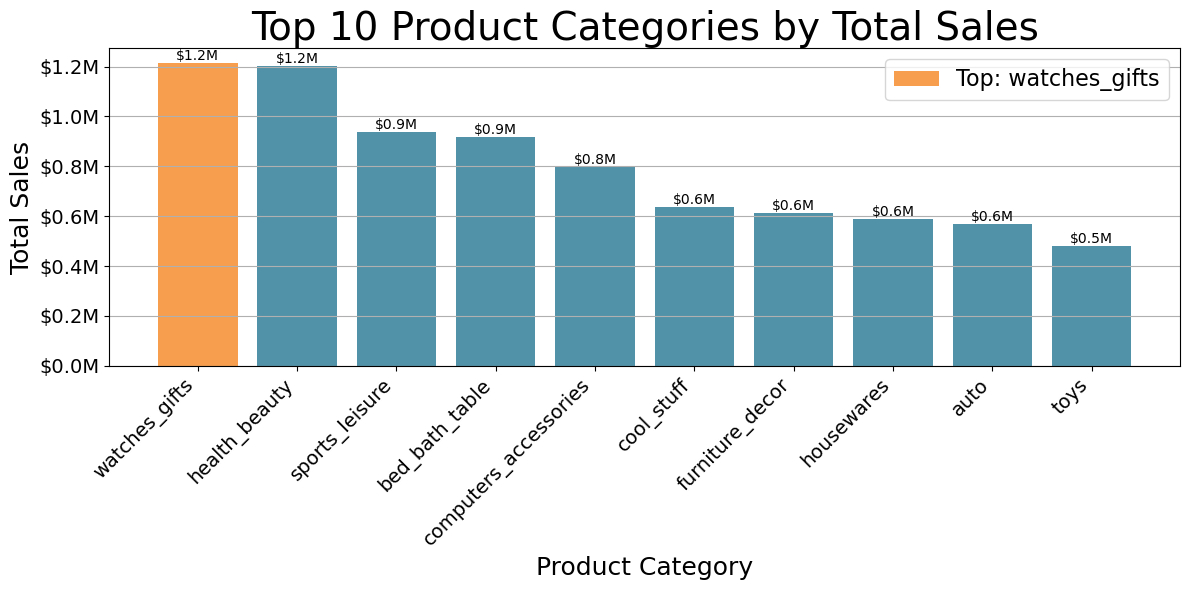

In [33]:

# Query to get top 10 product categories by total sales
query = """
SELECT
  product_category_name,
  SUM(price) AS total_sales
FROM
  `sctp-data-eng-ecomm.ecomm_dev.fact_order_items`
WHERE
  product_category_name IS NOT NULL
GROUP BY
  product_category_name
ORDER BY
  total_sales DESC
LIMIT 10;
"""

# Load data into DataFrame
df = client.query(query).to_dataframe()

# Identify index of top category
max_index = df['total_sales'].idxmax()
highlight_color = '#f69e4e'
base_color = '#5192A9'

# Apply colors: highlight the highest bar
colors = [highlight_color if i == max_index else base_color for i in range(len(df))]

# Plotting
plt.figure(figsize=(12, 6))
bars = plt.bar(df["product_category_name"], df["total_sales"], color=colors)

# Title and labels
plt.title("Top 10 Product Categories by Total Sales", fontsize=28)
plt.xlabel("Product Category", fontsize=18)
plt.ylabel("Total Sales", fontsize=18)
plt.xticks(rotation=45, ha='right', fontsize=14)
plt.yticks(fontsize=14)
plt.legend([f'Top: {df["product_category_name"][max_index]}'], fontsize=16)
plt.grid(axis='y')

# Format y-axis ticks as millions
plt.gca().yaxis.set_major_formatter(mtick.FuncFormatter(lambda x, _: f'${x/1e6:.1f}M'))

# Add text labels on bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height + 100,
             f"${height / 1e6:.1f}M", ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()
